In [ ]:
!pip install tensorflow==2.15.1
!pip install tensorflow-recommenders==0.7.3

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

import tensorflow as tf
import tensorflow_recommenders as tfrs

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import urllib.request
from scipy.special import softmax
import csv

from tqdm import tqdm
tqdm.pandas()

# Introduction

The purpose of this work is to see the impact of review texts on recommendatition algorithms. Both retrieval and rank models trained on Amazon reviews dataset. In each experiment, a different set of feature was evaluated. For the sentiment analysis, RoBERTa was employed.


# Models

## 1. User Model

### 1.1 Base Model

UserId ----> StringLookup (equivalent to the OrdinalEncoder) ----> Embedding (1,16) => User Embedding ($u_v)$
 (1,16)

### 1.2 Summary Only Model

UserId ----> StringLookup (equivalent to the OrdinalEncoder) ----> Embedding (1,16) => User Embedding ($u_v)$
 (1,16)

ReviewSummary ----> TextVectorizer (split the words and encode them) ----> Embedding + GlobalAverage1d (1,16) => Summary Embedding ($u_z$)
 (1,16)

Concatenate($u_v$,$u_z$) => UserSummaryEmbedding ($u_m$) (1,32)

FFN($u_m$) (1,16) => UserSummary Vector (1,16)

### 1.3 Sentiment Only Model

UserId ----> StringLookup (equivalent to the OrdinalEncoder) ----> Embedding (1,16) => User Embedding ($u_v$)
(1,16)

Sentiment Scores ($u_t$) (1,3)

Concatenate($u_v$,$u_t$) => UserSentimentEmbedding ($u_m$) (1,19)

FFN($u_m$) (1,16) => UserSentiment Vector (1,16)


### 1.4 Complete Model

UserId ----> StringLookup (equivalent to the OrdinalEncoder) ----> Embedding (1,16) => User Embedding ($u_v)$
(1,16)

ReviewSummary ----> TextVectorizer (split the words and encode them) ----> Embedding + GlobalAverage1d (1,16) => Summary Embedding ($u_z$)
(1,16)

Sentiment Scores ($u_t$) (1,3)

Concatenate($u_v$,$u_t$,$u_z$) => UserSentimentEmbedding ($u_m$) (1,35)

FFN($u_m$) (1,16) => UserSummary Vector (1,16)


## 2. Product Model

ProductId ----> StringLookup ----> Embedding (1,16) => Product Embedding ($u_i$) (1,16)


## 3. Retrieval Model

User Inputs (Reviews, Text Summary, Sentiment Scores) ----> UserModel (1,16) => User Vector ($u_b$) (1,16)

ProductIds ----> ProductModel (1,16) => Product Embedding ($u_i$) (1,16)

During the learning process, depending on the previous interactions, $u_b$ and $u_i$ come closer or further from each other. At the end of the learning process, if feature representation $b$ and product representation $i$ are highly correlated, the degree between each vector decreases hence the dot product ($u_b . u_i$) increases. 

### 3.1. Retrieval Model Objective:

max Top-K Categorical Accuracy (min Categorical Cross Entropy)

>**Example scenario:** User A previously bought cars B and C. The available cars are B, C and D.
>
>At iteration t, $u_i . u_b$ are 0.99,0.9,0.8. Car labels are 1,1,0. Thus categorical cross entropy:
>
>```python
>cce= keras.losses.CategoricalCrossentropy()
>cce(np.array([1,1,0]),np.array([0.99,0.9,0.8]))
><tf.Tensor: shape=(), dtype=float32, numpy=2.0944934>
>```
>
>Then model updates the probabilities at iteration t+1 as 0.99,0.95,0.1:
>
>```python
>cce(np.array([1,1,0]),np.array([0.99,0.9,0.1]))
><tf.Tensor: shape=(), dtype=float32, numpy=1.4916801>
>```

## 4. Ranking Model

User Inputs (Reviews, Text Summary, Sentiment Scores) ----> UserModel (1,16) => User Vector ($u_b$) (1,16)

ProductIds ----> ProductModel (1,16) => Product Embedding ($u_i$) (1,16)

Concatenate($u_b$,$u_i$) => ProductUser Embedding ($u_r$) (1,32)

FFN($u_r$) ----> Rating Prediction

### 4.1. Ranking Model Objective:

min RMSE(Rating Prediction, Rating)

## Results

Review summaries significantly improved the retrieval performance. Interestingly enough, using review summaries and and sentiments together yields better outcomes compared to the base model but still, the end performance is worse compared to the summary only model. (1st figure)

Sentiment scores are not completely useless. In fact, these scores significantly enhance the rating predictions. (2nd figure)

In [3]:
!wget https://raw.githubusercontent.com/imsreecharan/datasets_/refs/heads/master/amazon_reviews.csv


--2025-01-08 11:20:29--  https://raw.githubusercontent.com/imsreecharan/datasets_/refs/heads/master/amazon_reviews.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 903820 (883K) [text/plain]
Saving to: ‘amazon_reviews.csv’

amazon_reviews.csv  100%[===================>] 882.64K  --.-KB/s    in 0.06s   

2025-01-08 11:20:29 (15.4 MB/s) - ‘amazon_reviews.csv’ saved [903820/903820]



In [4]:
reviews = pd.read_csv('amazon_reviews.csv',index_col = 0).rename(columns = {'asin': 'product_id'})[["product_id","overall","reviewerID","summary"]]
reviews.head()

,product_id,overall,reviewerID,summary
0,0528881469,5.0,AO94DHGC771SJ,Gotta have GPS!
1,0528881469,1.0,AMO214LNFCEI4,Very Disappointed
2,0528881469,3.0,A3N7T0DY83Y4IG,1st impression
3,0528881469,2.0,A1H8PY3QHMQQA0,"Great grafics, POOR GPS"
4,0528881469,1.0,A24EV6RXELQZ63,"Major issues, only excuses for support"


# 1. Sentiment Analysis of Summaries

In [5]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)


labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]


model = AutoModelForSequenceClassification.from_pretrained(MODEL)
# model.save_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [6]:
def get_roberta_scores(row):
  encoded_text = tokenizer(row["summary"],return_tensors ="pt")
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  return scores

reviews[["negative","neutral","positive"]] = reviews.progress_apply(get_roberta_scores,axis = 1,result_type = "expand")

100%|██████████| 999/999 [02:54<00:00,  5.71it/s]


# 2. Creating the Models

In [9]:
unique_product_id = np.unique(reviews["product_id"])
unique_reviewerID = np.unique(reviews["reviewerID"])

dataset = tf.data.Dataset.from_tensor_slices({
    "reviewerID": reviews["reviewerID"].values,
    "product_id": reviews["product_id"].values,
    "summary": reviews["summary"].values,
    "negative": reviews["negative"].values,
    "neutral": reviews["neutral"].values,
    "positive": reviews["positive"].values,
    "overall": reviews["overall"].values
})

candidate_dataset = tf.data.Dataset.from_tensor_slices({"product_id": unique_product_id})

shuffled = dataset.shuffle(len(dataset), seed=42, reshuffle_each_iteration=False)
train = shuffled.take(int(len(dataset) * 0.8)).batch(32)
test = shuffled.skip(int(len(dataset) * 0.8)).batch(32)

In [10]:
class ProductModel(tf.keras.Model):
  def __init__(self):
    super().__init__()

    self.product_model = tf.keras.Sequential([tf.keras.layers.StringLookup(vocabulary = unique_product_id),
                                              tf.keras.layers.Embedding(len(unique_product_id) + 1, 16)])

  def call(self,inputs):
    return self.product_model(inputs["product_id"])

In [11]:
class UserModel(tf.keras.Model):
  def __init__(self,use_sentiment_scores,use_summary):
    super().__init__()

    self.use_sentiment_scores = use_sentiment_scores
    self.use_summary = use_summary

    self.user_model = tf.keras.Sequential([tf.keras.layers.StringLookup(vocabulary = unique_reviewerID),
                                           tf.keras.layers.Embedding(len(unique_reviewerID) + 1, 16)])

    self.text_vectorizer = tf.keras.layers.TextVectorization(max_tokens = 10000)
    self.text_vectorizer.adapt(reviews["summary"].values)

    if self.use_summary:
      self.summary_model = tf.keras.Sequential([self.text_vectorizer,
                                              tf.keras.layers.Embedding(10000, 16,mask_zero = True),
                                              tf.keras.layers.GlobalAveragePooling1D()])

    if self.use_summary or self.use_sentiment_scores:
      self.dense = tf.keras.layers.Dense(16)

  def call(self, inputs):
    components = [self.user_model(inputs["reviewerID"])]

    if self.use_summary:
        components.append(self.summary_model(inputs["summary"]))

    if self.use_sentiment_scores:
        components.extend([
            tf.expand_dims(inputs["negative"], axis=1),
            tf.expand_dims(inputs["neutral"], axis=1),
            tf.expand_dims(inputs["positive"], axis=1),
        ])

    if self.use_summary or self.use_sentiment_scores:
      return self.dense(tf.concat(components, axis=1))

    return components[0]

In [12]:
class Retrieval(tfrs.Model):
  def __init__(self,user_model,product_model):
    super().__init__()
    self.user_model = user_model
    self.product_model = product_model
    self.task = tfrs.tasks.Retrieval(metrics = tfrs.metrics.FactorizedTopK(candidates = candidate_dataset.batch(128).map(product_model)))

  def compute_loss(self,inputs,training = False):
    interaction_vector = self.user_model(inputs)
    product_embeddings = self.product_model(inputs)
    return self.task(interaction_vector,product_embeddings)



In [13]:
class Rank(tfrs.Model):
  def __init__(self,user_model,product_model):
    super().__init__()
    self.user_model = user_model
    self.product_model = product_model
    self.task = tfrs.tasks.Ranking(loss = tf.keras.losses.MeanSquaredError(),
                                  metrics = [tf.keras.metrics.RootMeanSquaredError()])

    self.rank_model = tf.keras.Sequential([tf.keras.layers.Dense(32,activation = "relu"),
                                           tf.keras.layers.Dense(16,activation = "relu"),
                                          tf.keras.layers.Dense(1)])

  def call(self,inputs):
    interaction_vector = self.user_model(inputs)
    product_embeddings = self.product_model(inputs)
    return self.rank_model(tf.concat([interaction_vector,product_embeddings],axis = 1))

  def compute_loss(self,inputs,training = False):
    rating_predictions = self(inputs)
    return self.task(labels = inputs["overall"],predictions = rating_predictions)

# 3. Experimenting with the Retrieval Model

In [14]:
tf.random.set_seed(42)
USE_SENTIMENT_SCORES = False
USE_SUMMARY = False

retrieval_model = Retrieval(UserModel(use_sentiment_scores=USE_SENTIMENT_SCORES,use_summary=USE_SUMMARY),
                            ProductModel())

retrieval_model.compile(optimizer = tf.keras.optimizers.Adagrad(0.01))

base_retrieval_model = retrieval_model.fit(train, epochs=10,validation_data = test)

Epoch 1/10
25/25 [==============================] - 9s 199ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.1114 - factorized_top_k/top_10_categorical_accuracy: 0.2353 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 110.5600 - regularization_loss: 0.0000e+00 - total_loss: 110.5600 - val_factorized_top_k/top_1_categorical_accuracy: 0.0250 - val_factorized_top_k/top_5_categorical_accuracy: 0.1100 - val_factorized_top_k/top_10_categorical_accuracy: 0.2150 - val_factorized_top_k/top_50_categorical_accuracy: 1.0000 - val_factorized_top_k/top_100_categorical_accuracy: 1.0000 - val_loss: 16.6340 - val_regularization_loss: 0.0000e+00 - val_total_loss: 16.6340
Epoch 2/10
25/25 [==============================] - 3s 119ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.1602 - factorized_top_k/top_10_

In [15]:
tf.random.set_seed(42)
USE_SENTIMENT_SCORES = False
USE_SUMMARY = True

retrieval_model = Retrieval(UserModel(use_sentiment_scores=USE_SENTIMENT_SCORES,use_summary=USE_SUMMARY),
                            ProductModel())

retrieval_model.compile(optimizer = tf.keras.optimizers.Adagrad(0.01))

summary_retrieval_model = retrieval_model.fit(train, epochs=10,validation_data = test)

Epoch 1/10
25/25 [==============================] - 6s 188ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0976 - factorized_top_k/top_10_categorical_accuracy: 0.2328 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 110.5603 - regularization_loss: 0.0000e+00 - total_loss: 110.5603 - val_factorized_top_k/top_1_categorical_accuracy: 0.0350 - val_factorized_top_k/top_5_categorical_accuracy: 0.1400 - val_factorized_top_k/top_10_categorical_accuracy: 0.2700 - val_factorized_top_k/top_50_categorical_accuracy: 1.0000 - val_factorized_top_k/top_100_categorical_accuracy: 1.0000 - val_loss: 16.6179 - val_regularization_loss: 0.0000e+00 - val_total_loss: 16.6179
Epoch 2/10
25/25 [==============================] - 4s 156ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0013 - factorized_top_k/top_5_categorical_accuracy: 0.1652 - factorized_top_k/top_10_cate

In [16]:
tf.random.set_seed(42)
USE_SENTIMENT_SCORES = True
USE_SUMMARY = False

retrieval_model = Retrieval(UserModel(use_sentiment_scores=USE_SENTIMENT_SCORES,use_summary=USE_SUMMARY),
                            ProductModel())
retrieval_model.compile(optimizer = tf.keras.optimizers.Adagrad(0.01))

sentiment_retrieval_model = retrieval_model.fit(train, epochs=10,validation_data = test)

Epoch 1/10
25/25 [==============================] - 3s 82ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0050 - factorized_top_k/top_5_categorical_accuracy: 0.1627 - factorized_top_k/top_10_categorical_accuracy: 0.3354 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 110.5692 - regularization_loss: 0.0000e+00 - total_loss: 110.5692 - val_factorized_top_k/top_1_categorical_accuracy: 0.1100 - val_factorized_top_k/top_5_categorical_accuracy: 0.2500 - val_factorized_top_k/top_10_categorical_accuracy: 0.3550 - val_factorized_top_k/top_50_categorical_accuracy: 1.0000 - val_factorized_top_k/top_100_categorical_accuracy: 1.0000 - val_loss: 16.6554 - val_regularization_loss: 0.0000e+00 - val_total_loss: 16.6554
Epoch 2/10
25/25 [==============================] - 2s 95ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0363 - factorized_top_k/top_5_categorical_accuracy: 0.2390 - factorized_top_k/top_10_categorica

In [17]:
tf.random.set_seed(42)
USE_SENTIMENT_SCORES = True
USE_SUMMARY = True

retrieval_model = Retrieval(UserModel(use_sentiment_scores=USE_SENTIMENT_SCORES,use_summary=USE_SUMMARY),
                            ProductModel())
retrieval_model.compile(optimizer = tf.keras.optimizers.Adagrad(0.01))

complete_retrieval_model = retrieval_model.fit(train, epochs=10,validation_data = test)

Epoch 1/10
25/25 [==============================] - 3s 83ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0438 - factorized_top_k/top_5_categorical_accuracy: 0.2153 - factorized_top_k/top_10_categorical_accuracy: 0.2904 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 110.5098 - regularization_loss: 0.0000e+00 - total_loss: 110.5098 - val_factorized_top_k/top_1_categorical_accuracy: 0.1250 - val_factorized_top_k/top_5_categorical_accuracy: 0.2650 - val_factorized_top_k/top_10_categorical_accuracy: 0.3250 - val_factorized_top_k/top_50_categorical_accuracy: 1.0000 - val_factorized_top_k/top_100_categorical_accuracy: 1.0000 - val_loss: 16.6404 - val_regularization_loss: 0.0000e+00 - val_total_loss: 16.6404
Epoch 2/10
25/25 [==============================] - 2s 69ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0538 - factorized_top_k/top_5_categorical_accuracy: 0.2791 - factorized_top_k/top_10_categorica

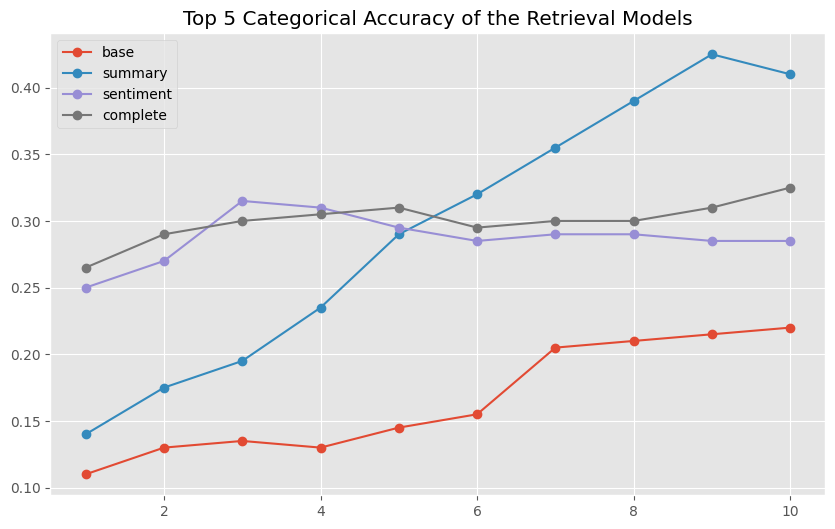

In [18]:
plt.figure(figsize = (10,6))
epochs = range(1,11)
plt.plot(epochs,base_retrieval_model.history["val_factorized_top_k/top_5_categorical_accuracy"],label = "base",marker = "o")
plt.plot(epochs,summary_retrieval_model.history["val_factorized_top_k/top_5_categorical_accuracy"],label = "summary",marker = "o")
plt.plot(epochs,sentiment_retrieval_model.history["val_factorized_top_k/top_5_categorical_accuracy"],label = "sentiment",marker = "o")
plt.plot(epochs,complete_retrieval_model.history["val_factorized_top_k/top_5_categorical_accuracy"],label = "complete",marker = "o")
plt.title("Top 5 Categorical Accuracy of the Retrieval Models")
plt.legend()
plt.show()


# Experimenting with the Rank Model

In [19]:
tf.random.set_seed(42)
USE_SENTIMENT_SCORES = False
USE_SUMMARY = False



rank_model = Rank(UserModel(use_sentiment_scores=USE_SENTIMENT_SCORES,use_summary=USE_SUMMARY),
                  ProductModel())

rank_model.compile(optimizer = tf.keras.optimizers.Adagrad(0.01))

base_rank_model = rank_model.fit(train, epochs=10,validation_data = test)

Epoch 1/10
25/25 [==============================] - 2s 12ms/step - root_mean_squared_error: 3.7910 - loss: 14.2316 - regularization_loss: 0.0000e+00 - total_loss: 14.2316 - val_root_mean_squared_error: 3.0478 - val_loss: 12.2227 - val_regularization_loss: 0.0000e+00 - val_total_loss: 12.2227
Epoch 2/10
25/25 [==============================] - 0s 3ms/step - root_mean_squared_error: 2.3297 - loss: 5.3261 - regularization_loss: 0.0000e+00 - total_loss: 5.3261 - val_root_mean_squared_error: 1.6179 - val_loss: 2.7724 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2.7724
Epoch 3/10
25/25 [==============================] - 0s 16ms/step - root_mean_squared_error: 1.4385 - loss: 2.0458 - regularization_loss: 0.0000e+00 - total_loss: 2.0458 - val_root_mean_squared_error: 1.3632 - val_loss: 1.1098 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1098
Epoch 4/10
25/25 [==============================] - 0s 8ms/step - root_mean_squared_error: 1.2907 - loss: 1.6467 - regularization_

In [20]:
tf.random.set_seed(42)
USE_SENTIMENT_SCORES = False
USE_SUMMARY = True

rank_model = Rank(UserModel(use_sentiment_scores=USE_SENTIMENT_SCORES,use_summary=USE_SUMMARY),
                  ProductModel())

rank_model.compile(optimizer = tf.keras.optimizers.Adagrad(0.01))

summary_rank_model = rank_model.fit(train, epochs=10,validation_data = test)

Epoch 1/10
25/25 [==============================] - 2s 18ms/step - root_mean_squared_error: 3.7616 - loss: 13.9605 - regularization_loss: 0.0000e+00 - total_loss: 13.9605 - val_root_mean_squared_error: 2.8113 - val_loss: 10.4993 - val_regularization_loss: 0.0000e+00 - val_total_loss: 10.4993
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - root_mean_squared_error: 1.8911 - loss: 3.4894 - regularization_loss: 0.0000e+00 - total_loss: 3.4894 - val_root_mean_squared_error: 1.2539 - val_loss: 0.9780 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.9780
Epoch 3/10
25/25 [==============================] - 0s 8ms/step - root_mean_squared_error: 1.1813 - loss: 1.3815 - regularization_loss: 0.0000e+00 - total_loss: 1.3815 - val_root_mean_squared_error: 1.2057 - val_loss: 0.6001 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.6001
Epoch 4/10
25/25 [==============================] - 0s 9ms/step - root_mean_squared_error: 1.1245 - loss: 1.2516 - regularization_l

In [21]:
tf.random.set_seed(42)
USE_SENTIMENT_SCORES = True
USE_SUMMARY = False

rank_model = Rank(UserModel(use_sentiment_scores=USE_SENTIMENT_SCORES,use_summary=USE_SUMMARY),
                  ProductModel())
rank_model.compile(optimizer = tf.keras.optimizers.Adagrad(0.01))

sentiment_rank_model = rank_model.fit(train, epochs=10,validation_data = test)

Epoch 1/10
25/25 [==============================] - 2s 15ms/step - root_mean_squared_error: 3.3076 - loss: 10.6651 - regularization_loss: 0.0000e+00 - total_loss: 10.6651 - val_root_mean_squared_error: 1.6693 - val_loss: 2.7518 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2.7518
Epoch 2/10
25/25 [==============================] - 0s 8ms/step - root_mean_squared_error: 1.1163 - loss: 1.2341 - regularization_loss: 0.0000e+00 - total_loss: 1.2341 - val_root_mean_squared_error: 0.9225 - val_loss: 0.3993 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.3993
Epoch 3/10
25/25 [==============================] - 0s 9ms/step - root_mean_squared_error: 0.9242 - loss: 0.8520 - regularization_loss: 0.0000e+00 - total_loss: 0.8520 - val_root_mean_squared_error: 0.8945 - val_loss: 0.3356 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.3356
Epoch 4/10
25/25 [==============================] - 0s 9ms/step - root_mean_squared_error: 0.8881 - loss: 0.7857 - regularization_los

In [22]:
tf.random.set_seed(42)
USE_SENTIMENT_SCORES = True
USE_SUMMARY = True

rank_model = Rank(UserModel(use_sentiment_scores=USE_SENTIMENT_SCORES,use_summary=USE_SUMMARY),
                  ProductModel())
rank_model.compile(optimizer = tf.keras.optimizers.Adagrad(0.01))

complete_rank_model = rank_model.fit(train, epochs=10,validation_data = test)

Epoch 1/10
25/25 [==============================] - 3s 38ms/step - root_mean_squared_error: 3.3821 - loss: 11.1295 - regularization_loss: 0.0000e+00 - total_loss: 11.1295 - val_root_mean_squared_error: 1.6533 - val_loss: 3.0314 - val_regularization_loss: 0.0000e+00 - val_total_loss: 3.0314
Epoch 2/10
25/25 [==============================] - 0s 7ms/step - root_mean_squared_error: 1.0956 - loss: 1.1804 - regularization_loss: 0.0000e+00 - total_loss: 1.1804 - val_root_mean_squared_error: 0.9270 - val_loss: 0.2869 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.2869
Epoch 3/10
25/25 [==============================] - 0s 9ms/step - root_mean_squared_error: 0.9107 - loss: 0.8220 - regularization_loss: 0.0000e+00 - total_loss: 0.8220 - val_root_mean_squared_error: 0.8999 - val_loss: 0.2722 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.2722
Epoch 4/10
25/25 [==============================] - 0s 9ms/step - root_mean_squared_error: 0.8764 - loss: 0.7618 - regularization_los

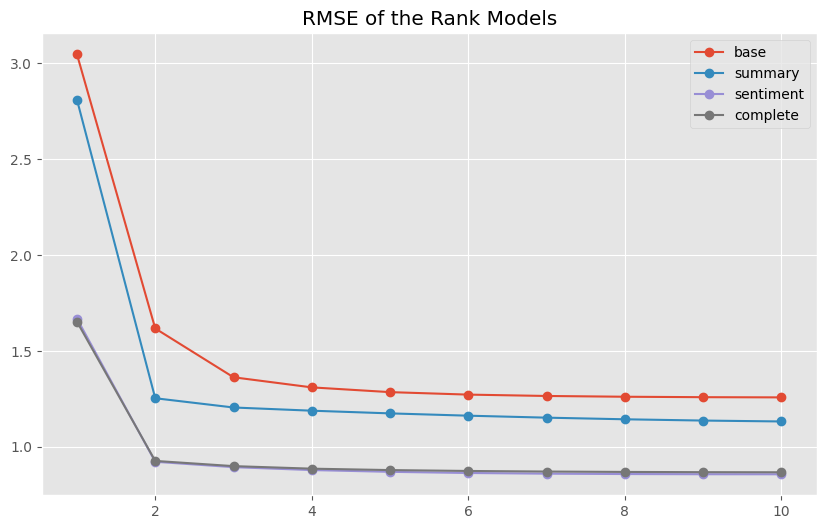

In [23]:
plt.figure(figsize = (10,6))
epochs = range(1,11)
plt.plot(epochs,base_rank_model.history["val_root_mean_squared_error"],label = "base",marker = "o")
plt.plot(epochs,summary_rank_model.history["val_root_mean_squared_error"],label = "summary",marker = "o")
plt.plot(epochs,sentiment_rank_model.history["val_root_mean_squared_error"],label = "sentiment",marker = "o")
plt.plot(epochs,complete_rank_model.history["val_root_mean_squared_error"],label = "complete",marker = "o")
plt.title("RMSE of the Rank Models")

plt.legend()
plt.show()